# Homework 7: Kernel K-Means and EM

By Rachel Manzelli and Brian Kulis with the help of N. Frumkin, K. Chauhan, and A. Tsiligkaridis

*Please submit to Blackboard by 11:59pm on* **Friday, April 5.**

## Problem 1: Kernel K-Means

In this exercise, we will consider how one may go about performing non-linear machine learning by adapting machine learning algorithms that we have discussed in class.  We will discuss one particular approach that has been widely used throughout machine learning.  Recall the discussion from lecture: we take our feature vectors $\boldsymbol{x}_1, ..., \boldsymbol{x}_n$ and apply a non-linear function $\phi$ to each point to yield $\phi(\boldsymbol{x}_1), ..., \phi(\boldsymbol{x}_n)$.  Then, if we apply a linear machine learning algorithm (e.g., k-means or SVM) on the mapped data, the linear boundary in the mapped space will correspond to a non-linear boundary in the input space.

We looked at one particular mapping in class.  Consider a two-dimensional feature vector $\boldsymbol{x} = (x_1 x_2)^T$, and define the function $\phi$ as 

\begin{equation*}
\phi(\boldsymbol{x}) = \left(
\begin{array}{c}
1 \\
\sqrt{2} x_1 \\
\sqrt{2} x_2 \\
\sqrt{2} x_1 x_2\\
x_1^2\\
x_2^2
\end{array} \right).
\end{equation*}

As discussed in class, the inner product $\phi(\boldsymbol{x}_i)^T \phi(\boldsymbol{x}_j)$ between two mapped vectors is equal to $(\boldsymbol{x}_i^T \boldsymbol{x}_j + 1)^2$; that is, one can compute the inner product between data points in the mapped space without explicitly forming the 6-dimensional mapped vectors for the data. Because applying such a mapping may be computationally expensive, this trick can allow us to run machine learning algorithms in the mapped space without explicitly forming the mappings. For instance, in a k-NN classifier, one must compute the (squared) Euclidean distance between a test point $\boldsymbol{x}_t$ and a training point $\boldsymbol{x}_i$. Expanding this distance out yields

\begin{equation*}
\|\boldsymbol{x}_t - \boldsymbol{x}_i\|^2_2 = (\boldsymbol{x}_t - \boldsymbol{x}_i)^T (\boldsymbol{x}_t - \boldsymbol{x}_i) = \boldsymbol{x}_t^T \boldsymbol{x}_t - 2 \boldsymbol{x}_t^T \boldsymbol{x}_i + \boldsymbol{x}_i^T \boldsymbol{x}_i.
\end{equation*}

Then, computing this distance after applying the mapping $\phi$ would be easy:

\begin{equation*}
\|\phi(\boldsymbol{x}_t) - \phi(\boldsymbol{x}_i)\|^2_2 = (\boldsymbol{x}_t^T \boldsymbol{x}_t + 1)^2 - 2 (\boldsymbol{x}_t^T \boldsymbol{x}_i + 1)^2 + (\boldsymbol{x}_i^T \boldsymbol{x}_i + 1)^2.
\end{equation*}

**a.** In the example above, the original feature vector was 2-dimensional. Show how to generalize the $\phi$ mapping to $d$-dimensional vector inputs such that the inner product between mapped vectors is $(\boldsymbol{x}_i^T \boldsymbol{x}_j + 1)^2$. Explicitly describe the embedding $\phi$; what dimensions does it have, and what values will it represent?

**b.** Consider extending the k-means algorithm to discover non-linear boundaries using the above mapping. In the k-means algorithm, the assignment step involves computing $\|\boldsymbol{x}_i - \boldsymbol{\mu}_j\|_2^2$ for each point $\boldsymbol{x}_i$ and each cluster mean $\boldsymbol{\mu}_j$.  Suppose we map the data via $\phi$. How would one compute the distance $\|\phi(\boldsymbol{x}_i) - \boldsymbol{\mu}_j\|^2_2$, where now $\boldsymbol{\mu}_j$ is the mean of the mapped data points? Be careful: one cannot simply compute

\begin{equation*}
 (\boldsymbol{x}_i^T \boldsymbol{x}_i + 1)^2 - 2 (\boldsymbol{x}_i^T \boldsymbol{\mu}_j + 1)^2 + (\boldsymbol{\mu}_j^T \boldsymbol{\mu}_j + 1)^2.
\end{equation*}

**c.** Write out pseudocode for the extension of k-means where this mapping is applied to the data. In your algorithm, be careful not to ever explicitly compute $\phi(\boldsymbol{x}_i)$ for any data vector; *only work with inner products in the algorithm.*

**d.** With this new mapping, what properties will the decision surface have (i.e, what could it look like)? Why is this?

**`[double click here to add a solution to Problem 1]`**

## Problem 2: Expectation-Maximization (E-M)

As you saw in lecture, the expectation-maximization algorithm is an iterative method to find maximum likelihood (ML) estimates of parameters in statistical models. The E-M algorithm alternates between performing an expectation (E) step, which creates a function for the expectation of the log-likelihood evaluated using the current estimate for the parameters, and a maximization (M) step, which computes parameters maximizing the expected log-likelihood found on the E step. This alternation repeats until convergence.

We would like you to perform E-M first on a sample Gaussian mixture model (GMM). Doing this will allow you to prove that your algorithm works, since you already know the parameters of the model. Follow the instructions step by step below.

In [1]:
from matplotlib.patches import Ellipse
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

**a. Data creation.** Create 3 2D Gaussian clusters of data, with the following means and covariances:

$\boldsymbol{\mu}_1 = [2,2]^T, \boldsymbol{\mu}_2 = [-2,-2]^T, \boldsymbol{\mu}_3 = [0,-2]^T$,

$\Sigma_1 = [[0.02,0];[0,0.02]]$, $\Sigma_2 = [[0.2,0];[0,0.2]]$, $\Sigma_3 = [[0.05,0];[0,0.05]]$ 

Create 50 points in each cluster and plot the data. The combination of these will serve as your Gaussian mixture model.

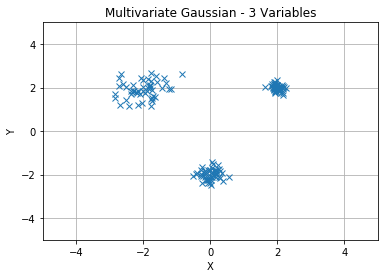

In [38]:
# Part a - data creation. This code is from the previous homework. You do not have to edit it.
num_pts = 50
x1, y1 = np.random.multivariate_normal([2,2], [[0.02,0],[0,0.02]], num_pts).T
x2, y2 = np.random.multivariate_normal([-2,2], [[0.2,0],[0,0.2]], num_pts).T
x3, y3 = np.random.multivariate_normal([0,-2], [[0.05,0],[0,0.05]], num_pts).T

# Concatenate clusters into one dataset
x_total = np.zeros((3*num_pts,1))
x_total[0:num_pts,0] = x1
x_total[num_pts:2*num_pts,0] = x2
x_total[2*num_pts:3*num_pts,0] = x3

y_total = np.zeros((3*num_pts,1))
y_total[0:num_pts,0] = y1
y_total[num_pts:2*num_pts,0] = y2
y_total[2*num_pts:3*num_pts,0] = y3

data = np.concatenate((x_total,y_total),axis=1)

# Plotting
plt.plot(x_total,y_total,'x')
ax = plt.gca()
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
plt.grid()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Multivariate Gaussian - 3 Variables')
plt.show()

**b. Fill in the code to complete the EM algorithm given below.** Remember, the EM algorithm is given by a process similar to k-means/DP-means in nature, since it is iterative. However, the actual calculations done are very different. For a Gaussian mixture model, they are described by:

*E-Step (Compute probabilities with given Gaussian parameters.* **This has already been completed for you. You can find the equations for this in the Discussion 8 folder on GitHub.**)


*M-Step (Update parameters. The subscript c denotes the parameter for a given cluster c, so this is calculated for each cluster.):*
\begin{equation*}
n\_per\_cluster = \sum_{i=1}^{n\_points} \gamma(z_{ic})
\end{equation*}

\begin{equation*}
\pi_c = \frac{n\_per\_cluster}{n\_points}
\end{equation*}

\begin{equation*}
\mu_c = \frac{1}{n\_per\_cluster} * \sum_{i=1}^{n\_points} \gamma(z_{ic}) * x_i 
\end{equation*}

\begin{equation*}
\Sigma_c = \frac{1}{n\_per\_cluster} * \sum_{i=1}^{n\_points} \gamma(z_{ic}) * (x_i - \mu_c)(x_i - \mu_c)^T 
\end{equation*}


*Repeat until convergence. To check for convergence, we check if the log-likelihood estimate is close enough to the previous estimate to stop the algorithm. To compute the log-likelihood estimate:*
\begin{equation*}
LL(\theta) = \sum_{i=1}^{n\_points} log \sum_{j=1}^{k} \pi_j * \frac{1}{2\pi|\Sigma_j|^\frac{1}{2}} exp(-0.5*(x_i - \mu_j)^T\Sigma_j^{-1}(x_i - \mu_j))
\end{equation*}

*Note that the "absolute value" signs around $\Sigma_j$ are actually indicative of the determinant of the covariance matrix. 

**In completing the algorithm below, you will complete the M-Step and the log-likelihood estimate. To compute the log-likelihood, we strongly recommend using `scipy.special.logsumexp`, as it is more numerically stable than manually computing.**

In [39]:
def EStep(data, n_points, k, pi, mu, cov):
    ## Performs the expectation (E) step ##
    ## You do not need to edit this function (actually, please do not edit it..)
    # The end result is an n_points x k matrix, where each element is the probability that
    # the ith point will be in the jth cluster.
    
    expectations = np.zeros((n_points, k)) # n_points x k np.array, where each row adds to 1
    denominators = []
    
    for i in np.arange(n_points):
        denominator = 0
        for j in np.arange(k):
            # Calculate denominator, which is a sum over k
            denominator_scale = pi[j] * 1/(2 * math.pi * np.sqrt(np.linalg.det(cov[j])))

            denom = denominator_scale * np.exp(-0.5 * (data[i].reshape(2,1) - mu[j]).T @ np.linalg.inv(cov[j]) @ (data[i].reshape(2,1) - mu[j]))
            denominator = np.add(denominator, denom)
        
        denominator = np.asscalar(denominator)
        denominators.append(denominator)
    
    for i in np.arange(n_points):
        numerator = 0
        for j in np.arange(k):
            # Calculate the numerator
            numerator_scale = pi[j] * 1/(2 * math.pi * np.sqrt(np.linalg.det(cov[j])))
            numer = np.exp(-0.5 * (data[i].reshape(2,1) - mu[j]).T @ np.linalg.inv(cov[j]) @ (data[i].reshape(2,1) - mu[j]))
            numerator = numerator_scale * numer
            
            # Set the probability of the ith point for the jth cluster
            expectations[i][j] = numerator/denominators[i]
            
    return expectations

def MStep(data, n_points, k, expectations):
    ## Performs the maximization (M) step ##
    
    # We clear the parameters completely, since we recompute them each time
    mu = [np.zeros((2,1)) for _ in np.arange(k)] # 3 2x1 np.arrays in a list
    cov = [np.zeros((2,2)) for _ in np.arange(k)] # 3 2x2 np.arrays in a list
    n_per_cluster = [0, 0, 0]
    pi = [0, 0, 0]
    
    ## YOUR CODE HERE ## 
    
    # Update number of points in each cluster
    n_cluster = np.sum(expectations, axis=0)
    for i in range(k):
        n_per_cluster[i] = n_cluster[i]

    
    # Update mixing weights
    for i in range(k):
        pi[i] = n_per_cluster[i]/n_points
    
    
    # Update means
    for i in range(k):
        for j in range(n_points):    
            mu[i] += np.reshape(expectations[j, i], (1,1)) * np.reshape(data[j, :], (2, 1))
        mu[i] /= n_per_cluster[i]
    
    
    # Update covariances
    for i in range(k):
        for j in range(n_points):
            spread = np.reshape(data[j, :], (2,1)) - mu[i]
            #print(np.shape(mu[i]))
            #print(np.shape(data[j,:]))
            cov[i] += expectations[j, i] * (spread@spread.T)
        cov[i] /= n_per_cluster[i]

    ## END YOUR CODE HERE ##
        
    return n_per_cluster, pi, mu, cov

def loglikelihood(data, n_points, k, pi, mu, cov):
    ## Calculates ML estimate ##
    likelihood = 0
    scale = [] # When using logsumexp the scale is required to be in an array
    exponents = [] # When using logsumexp the exponent is required to be in an array

    ## YOUR CODE HERE ##
    
    # Compute the log-likelihood estimate
    
    #Modifying code taken from calculating the denominator of the E step provided above
    for i in np.arange(n_points):
        for j in np.arange(k):

            scale.append(pi[j] * 1/(2 * math.pi * np.sqrt(np.linalg.det(cov[j]))))
            exponents.append(-0.5 * (data[i].reshape(2,1) - mu[j]).T @ np.linalg.inv(cov[j]) @ (data[i].reshape(2,1) - mu[j]))

        likelihood += logsumexp(a=exponents, b=scale)
        
    print(likelihood)
    ## END YOUR CODE HERE ##
    return likelihood

def ExpectationMaximization_GMM(data, n_per_cluster, n_points, k, pi, mu, cov):
    ## Performs expectation-maximization iteratively until convergence is reached ##
    # You do not need to edit this function.
    converged = False
    ML_estimate = 0
    
    while not converged:
        # E-Step: find probabilities
        expectations = EStep(data, n_points, k, pi, mu, cov)
        
        # M-Step: recompute parameters
        n_per_cluster, pi, mu, cov = MStep(data, n_points, k, expectations)

        # Plot the current parameters against the data
        # Ignore this, it just makes it look nice using some cool properties of eigenvectors!
        ## PLOT CODE ##
        lambda_1, v1 = np.linalg.eig(cov[0])
        lambda_1 = np.sqrt(lambda_1)
        lambda_2, v2 = np.linalg.eig(cov[1])
        lambda_2 = np.sqrt(lambda_2)
        lambda_3, v3 = np.linalg.eig(cov[2])
        lambda_3 = np.sqrt(lambda_3)

        # Plot data
        fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'}) 
        plt.plot(x_total,y_total,'x')
        plt.grid()
        
        # Plot ellipses
        ell1 = Ellipse(xy=(mu[0][0], mu[0][1]),
                  width=lambda_1[0]*3, height=lambda_1[1]*3,
                  angle=np.rad2deg(np.arccos(v1[0, 0])), linewidth=5, edgecolor='red', facecolor='none')
        ax.add_artist(ell1)
        
        ell2 = Ellipse(xy=(mu[1][0], mu[1][1]),
                  width=lambda_2[0]*3, height=lambda_2[1]*3,
                  angle=np.rad2deg(np.arccos(v2[0, 0])), linewidth=5, edgecolor='green', facecolor='none')
        ax.add_artist(ell2)
        
        ell3 = Ellipse(xy=(mu[2][0], mu[2][1]),
                  width=lambda_3[0]*3, height=lambda_3[1]*3,
                  angle=np.rad2deg(np.arccos(v3[0, 0])), linewidth=5, edgecolor='yellow', facecolor='none')
        ax.add_artist(ell3)
        
        axe = plt.gca()
        axe.set_xlim([-5,5])
        axe.set_ylim([-5,5])
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Multivariate Gaussian - 3 Variables')
        plt.show()
        ## END PLOT CODE ##
        
        # Check for convergence via log likelihood
        old_ML_estimate = np.copy(ML_estimate)
        ML_estimate = loglikelihood(data, n_points, k, pi, mu, cov)
        
        if abs(old_ML_estimate - ML_estimate) < 0.01:
            converged = 1
        
    return mu, cov

**c. Perform EM on the GMM you created.** Put it all together! Run the completed EM function on your dataset. (This part is already done for you, just run it and see the output.)

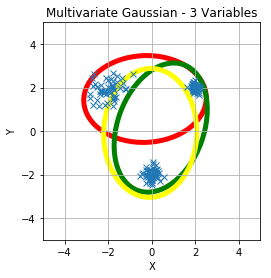

795.3695459416492


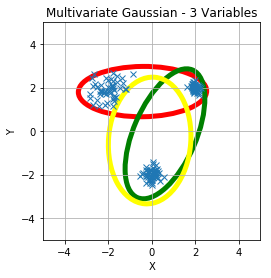

839.7529624613162


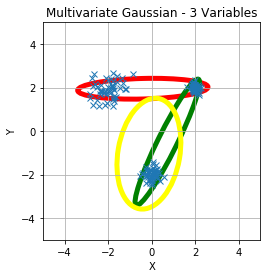

949.9123632580905


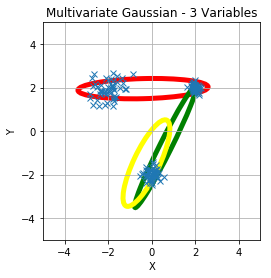

982.6655839004527


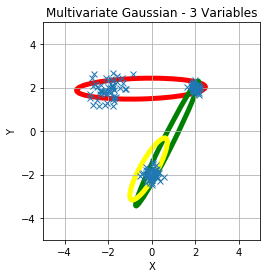

1001.3290682985603


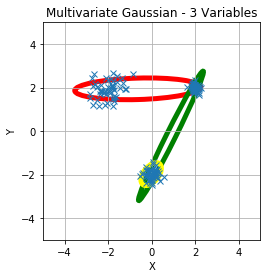

1060.1746434755698


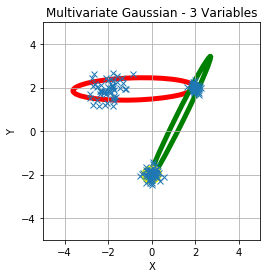

1160.2708534459298


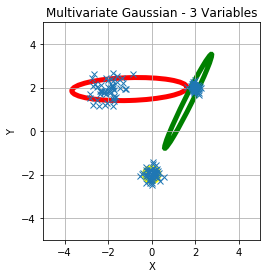

1197.763160148181


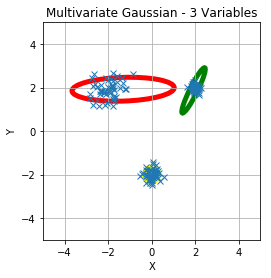

1223.3594191793388


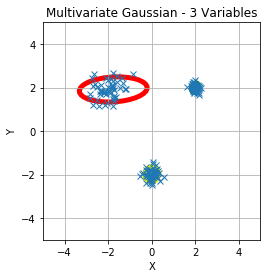

1333.0501066132633


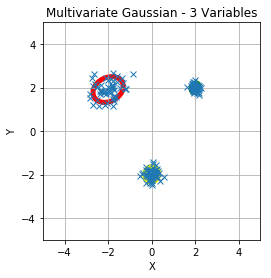

1333.6473675157167


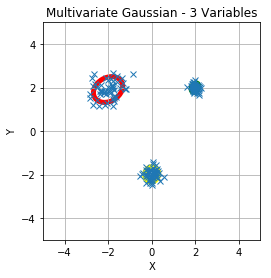

1333.3513936422776


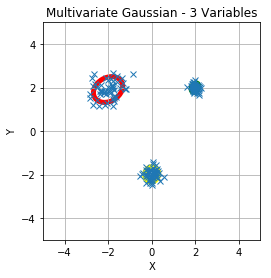

1333.3513936422771
The estimates of the parameters of the Gaussians are: 
Mu: [array([[-2.00556023],
       [ 1.91143827]]), array([[1.98994424],
       [1.99520681]]), array([[ 9.18954243e-04],
       [-1.98901140e+00]])]
Covariance: [array([[0.20077767, 0.04281131],
       [0.04281131, 0.15600529]]), array([[ 0.0133936 , -0.00470222],
       [-0.00470222,  0.02074309]]), array([[0.04683429, 0.00422003],
       [0.00422003, 0.05559702]])]


In [40]:
# Initialize total number of points (n), number of clusters (k),
# mixing weights (pi), means (mu) and covariance matrices (cov)
n_points = 150 # 150 points total
k = 3  # we know there are 3 clusters
mu = [(3 - (-3)) * np.random.rand(2,1) + (-3) for _ in np.arange(k)]
cov = [10 * np.identity(2) for _ in np.arange(k)]
n_per_cluster = [n_points/k for _ in np.arange(k)] # even split for now
pi = n_per_cluster

mu_estimate, cov_estimate = ExpectationMaximization_GMM(data, n_per_cluster, n_points, k, pi, mu, cov)
print("The estimates of the parameters of the Gaussians are: ")
print("Mu:", mu_estimate)
print("Covariance:", cov_estimate)

**d. Conclusion.** This dataset is linearly separable; k-means would also separate this data nicely, and is much easier to implement, as you saw in the last homework assignment. Would there be any reason to use k-means over E-M in this case, or vice versa? For what kinds of datasets would it make more sense to use E-M to cluster? Why?

**`[double click here to add a solution to part d]`**